## 1. Import Libraries

In [1]:
import os
import spacy
import pandas as pd
import re
from numpy.core.defchararray import find
import random
import matplotlib.pyplot as plt
import math
from spacy.pipeline import EntityRecognizer

print("spaCy version: ", spacy.__version__)

import numpy
numpy.random.seed(0)

spaCy version:  3.0.6


## 2. Download and Load Spacy Language Model

In [2]:
#Download spacy small model
# !python -m spacy download en_core_web_sm
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.blank('en')


## 3. Load processed (and cleaned) Reddit data

* Go through every sentence's all word-tag pair (except "NONE") and calculate the start and end index.
* After getting the (start, end) pair, check if this pair was already calcualted (i.e., either the start_index, OR end_index, OR both are matching with the ones in list), and if so, discard the pair and continue calculuting again, skipping over the one discarded.

In [9]:
col_names = ['text', 'entities']

data = pd.read_csv('./processed_data_v1.csv', names=col_names)
entity_list = data.entities.to_list()

DATA = []

for index, ent in enumerate(entity_list):
  if(ent=="split_sentences"):
    continue
  
  ent = ent.split("), (")
  ent[0] = re.sub("[([]", "", ent[0])
  ent[-1] = re.sub("[)]]", "", ent[-1])

  # Initilize index list, to store pairs of (start, end) indices
  indices_list = [(-1, -1), (-1, -1)]

  annot_list = []
  start_index = 0
  end_index = 0

  # Analyze current "split_sentences"'s all word-pairs
  for index_ent, word_pair in enumerate(ent):
    # Split the word and its pair
    word_pair_list = word_pair.split("'")[1::2]
    if word_pair_list[1]!="NONE":

      # Remove any leading or beginning blank space
      word_pair_list[0] = word_pair_list[0].strip()

      start_index = find(data['text'][index].lower(), word_pair_list[0]).astype(numpy.int64)
      start_index = start_index + 0
      end_index = start_index + len(word_pair_list[0])

      # Doesn't happen, just for a check  
      if start_index == -1:
        print("-1 error for the word: ", word_pair_list[0])
        print(data['text'][index])
        break

      # Check if this start_index and/or end_index is already in the list:
      # (To prevent overlapping with already tagged words)
      while True:
        if ((start_index, end_index) in indices_list) or (end_index in [i[1] for i in indices_list]) or (start_index in [i[0] for i in indices_list]):
          start_index = find(data['text'][index].lower(), word_pair_list[0], start=end_index+1).astype(numpy.int64)
          start_index = start_index + 0
          end_index = start_index + len(word_pair_list[0])

        else:
          indices_list.append((start_index, end_index))
          break

      annot_list.append((start_index, end_index, word_pair_list[1]))

  DATA.append((data['text'][index].lower(), {"entities": annot_list}))
  # print(indices_list)

-1 error for the word:  guitar
You may be best off with a powered wedge PA type amp The JBL Eon powered wedges are pretty good See this one for example
-1 error for the word:  guitars
For other s reference Gordon Reid s take on the subject For you Do some basic searching next time and get bent Namsayn
-1 error for the word:  ndrums
When music is converted to MIDI you can listen to songs for a ton If you want to remove one of the strings and play the guitar create a lot of frequencies The biggest voice is that we actually hear the recording Others call it dubbing and we don t hear it but dubbing makes a different violin sound than a piano Dubbing is a tool we call Tim Bray MIDI is like a music table read from a computer so the main field is not written when you convert MP3 to MIDI Pt calculates small changes in process and volume such as new notes and other recordings Human voices also have a rear sound so even listening like a piano the main instrument in most MIDI DLSes midi still pla

* Randomly pull out 10% segments for test data

In [4]:
random.shuffle(DATA)

test_length = math.floor((10/100) * len(DATA))
# test_length = 5

# First 5 elements form test data after shuffling
TEST_DATA = DATA[:test_length]

# for text, annotations in TEST_DATA:
#   print(text)
#   print(annotations)

TRAIN_DATA = DATA[test_length:len(DATA)]

# print("\n")
# for text, annotations in TRAIN_DATA:
#   print(text)
#   print(annotations)

print("\nTotal sentences: ", len(DATA))
print("\nLength of test data: ", len(TEST_DATA))
print("Length of train data: ", len(TRAIN_DATA))


Total sentences:  181

Length of test data:  18
Length of train data:  163


## 4. Preparing NER pipeline

* Getting the NER from pipeline

In [5]:
ner = nlp.get_pipe("ner")

* Adding labels to the NER

In [6]:
for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

* Add option to vary threashold for the textcat_multilabel model
*(Currently disabled)*

In [7]:
# from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL
# config = {
#    "threshold": 0.5,
#    "model": DEFAULT_MULTI_TEXTCAT_MODEL,
# }
# textcat = nlp.add_pipe("textcat_multilabel", config=config)

* Display all the components in the pipeline

In [8]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']

* Seperate enabled and disabled components of th pipeline

In [19]:
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

## 5. Train NER

In [17]:
# Import requirements
from spacy.util import minibatch, compounding
from spacy.training import Example
from spacy.scorer import Scorer
# from pathlib import Path

ITERATIONS = 40
DROPOUT = 0.1

scorer = Scorer()

# Store prediction and gold standard ref. for each sentence
# (to be used by Scorer)
example_list = []

# Store the PRF scores for every iteration
train_scores = []

# TRAINING THE MODEL
with nlp.select_pipes(enable=pipe_exceptions, disable=unaffected_pipes):
    # Create a list of Examples objects
    examples = []

    for text, annots in TRAIN_DATA:
        examples.append(Example.from_dict(nlp.make_doc(text), annots))

    # optimizer = nlp.create_optimizer()
    # get_examples = lambda: examples
    # optimizer = nlp.initialize(get_examples)

    for iteration in range(ITERATIONS):
        print("Iteration: ", iteration)
        # shuffling examples  before every iteration
        random.shuffle(examples)
        losses = {}

        # optimizer = nlp.resume_training()

        # batch up the examples using spaCy's minibatch
        batches = minibatch(examples, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            
            nlp.update(
                        batch,
                        drop = DROPOUT,  # dropout - make it harder to memorise data
                        losses=losses
                    )
            # print(batch)
            # print("Losses", losses)

        # After training every iteration, calculate scores
        # example_list = []
        # for text, annot in TRAIN_DATA:
        #     # Create a Doc of our text
        #     doc_gold_text = nlp.make_doc(text)
        #     pred_value = nlp(text)
        #     reference = (Example.from_dict(doc_gold_text, annot))
        #     gold_standard = {"entities": annot["entities"]}
        #     example_list.append(Example.from_dict(pred_value, gold_standard))
        #
        # # Generate per-entity scores by comparing predicted with gold-standard values
        # scores = scorer.score(examples=example_list)
        # train_scores.append(scores)

c:\users\archi\pycharmprojects\tsoai\venv\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "just google gut strings classical guitar and you c..." with entities "[(13, 40, 'INSTR')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
c:\users\archi\pycharmprojects\tsoai\venv\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "i don 2019t have the answer to your guitar questio..." with entities "[(36, 42, 'INSTR'), (91, 102, 'INSTR'), (124, 135,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
c:\users\archi

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39


* Save the model to disk

In [65]:
nlp.to_disk("./saved_model")

### 5.0 Plot PRF metrics

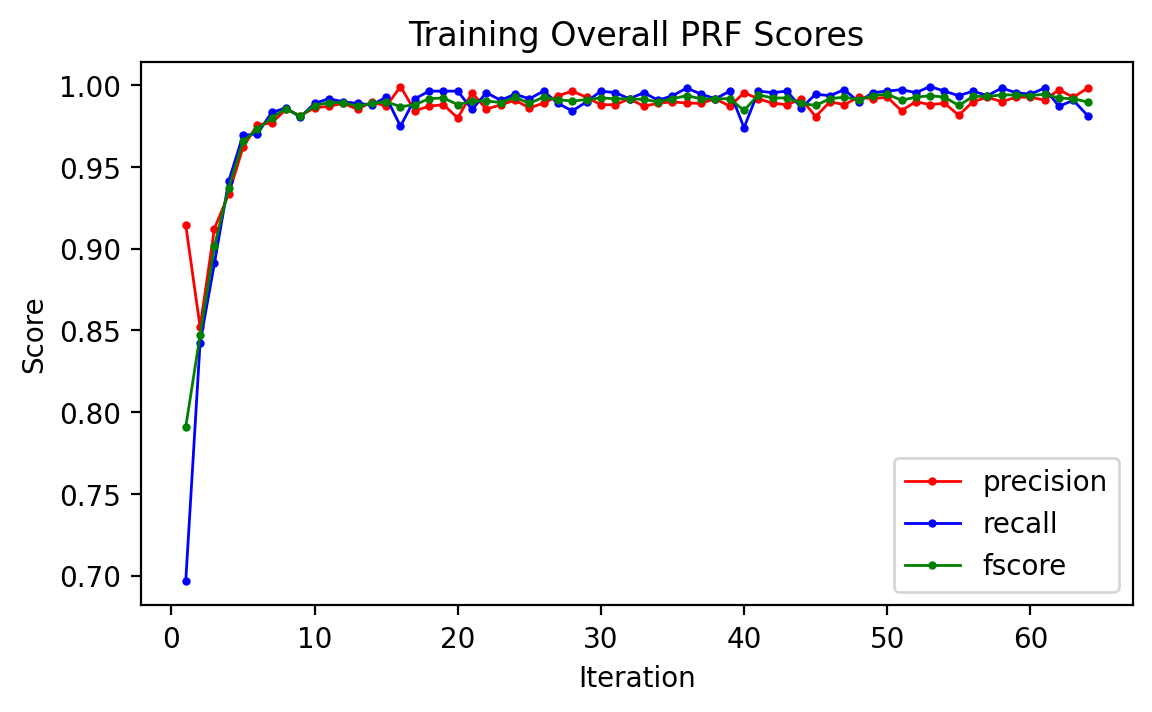

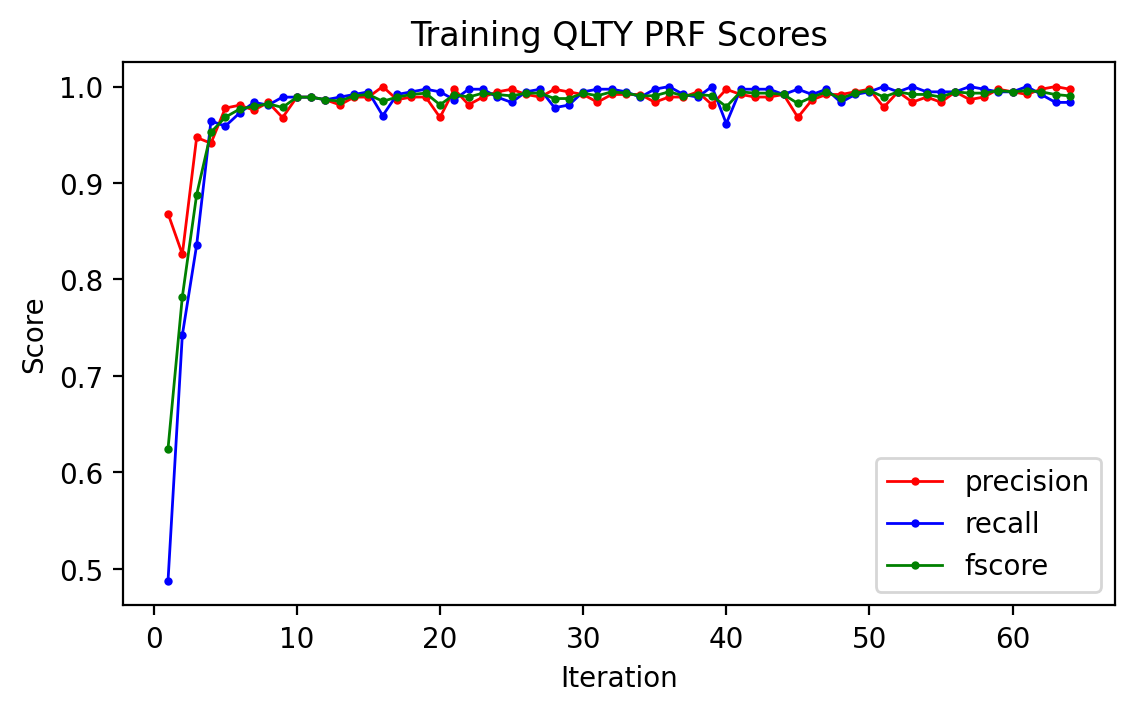

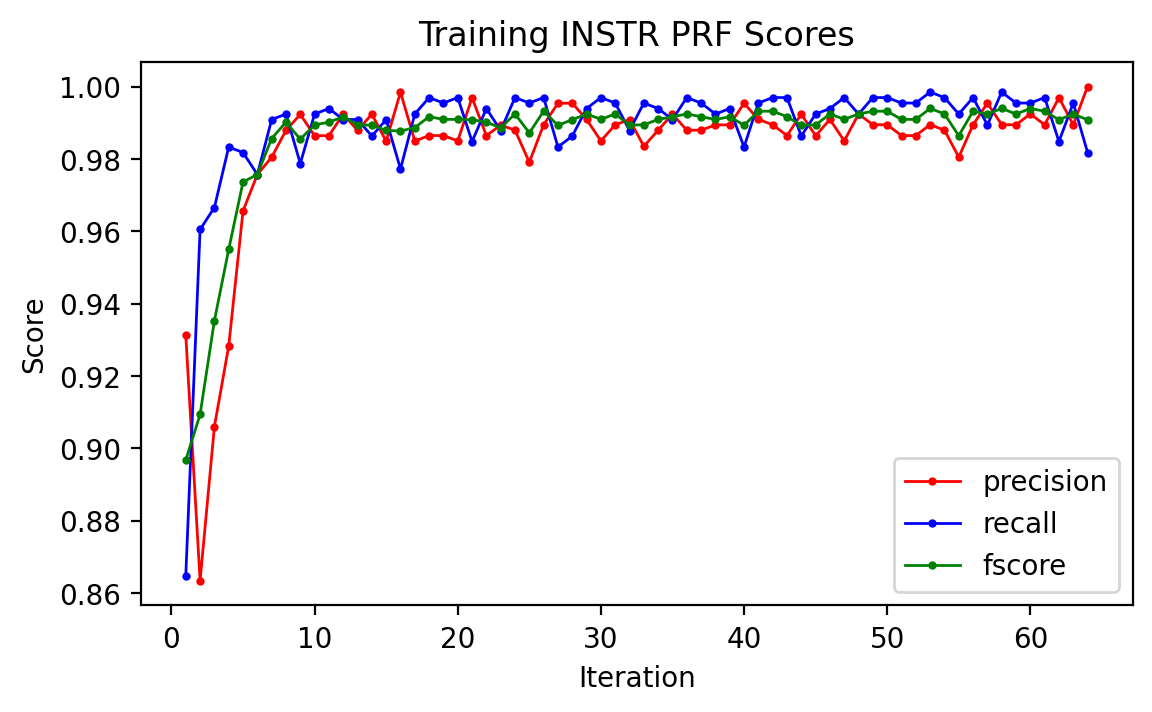

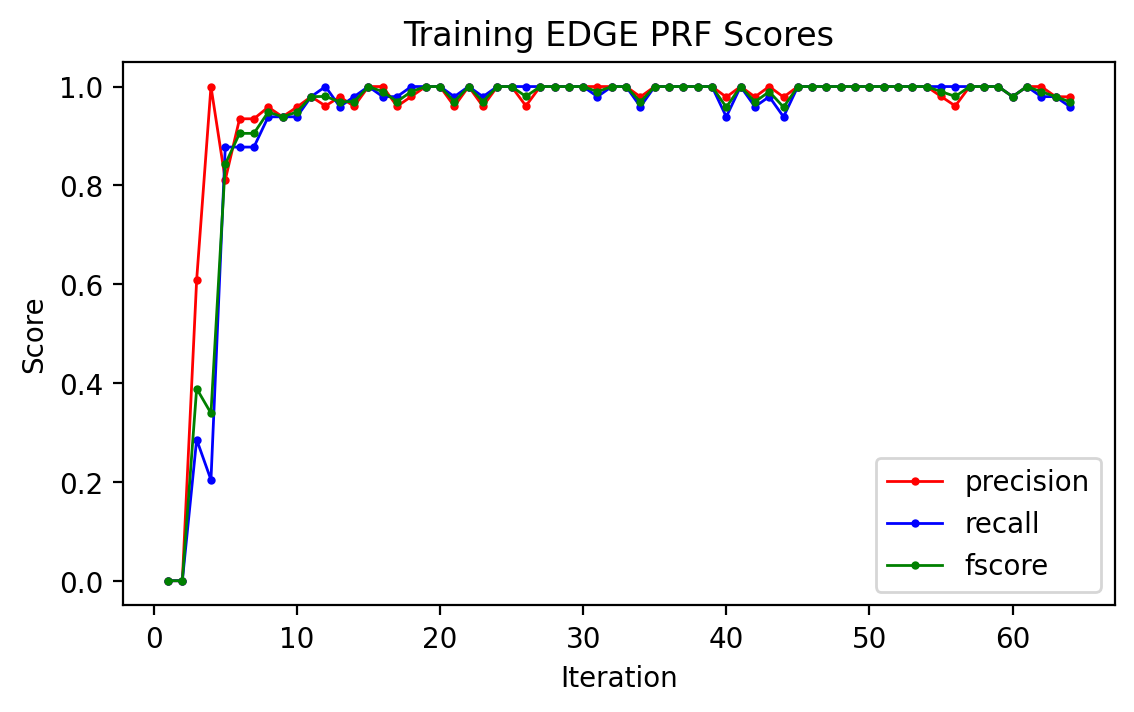

In [67]:
precision = []
recall = []
fscore = []

qlty_p = []
qlty_r = []
qlty_f = []

instr_p = []
instr_r = []
instr_f = []

edge_p = []
edge_r = []
edge_f = []

# Extract P, R, F from train_score
for i, train_score in enumerate(train_scores):
    for key, cat in train_score.items():
        if key == "ents_p": precision.append(cat)
        if key == "ents_r": recall.append(cat)
        if key == "ents_f": fscore.append(cat)
        if key == "ents_per_type":
            for attribute, value in cat.items():
                if attribute == "QLTY":
                    for k, sc in value.items():
                        if k == "p": qlty_p.append(sc)
                        if k == "r": qlty_r.append(sc)
                        if k == "f": qlty_f.append(sc)
                if attribute == "INSTR":
                    for k, sc in value.items():
                        if k == "p": instr_p.append(sc)
                        if k == "r": instr_r.append(sc)
                        if k == "f": instr_f.append(sc)
                if attribute == "EDGE":
                    for k, sc in value.items():
                        if k == "p": edge_p.append(sc)
                        if k == "r": edge_r.append(sc)
                        if k == "f": edge_f.append(sc)

def plot_graph(precision, recall, fscore, title, keyword):
    my_dpi = 200
    plt.rcParams['figure.figsize'] = 10, 5
    plt.figure(figsize=(1280 / my_dpi, 720 / my_dpi), dpi=my_dpi)
    x = list(range(1, ITERATIONS+1))
    plt.plot(x, precision, color='red', linestyle='solid', linewidth=1,
             marker='o', markerfacecolor='red', markersize=2)
    plt.plot(x, recall, color='blue', linestyle='solid', linewidth=1,
             marker='o', markerfacecolor='blue', markersize=2)
    plt.plot(x, fscore, color='green', linestyle='solid', linewidth=1,
             marker='o', markerfacecolor='green', markersize=2)
    plt.gca().legend(('precision', 'recall', 'fscore'), loc='best')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title(title)

    # If the directory does not exist, create it
    if not os.path.exists("img"):
        os.makedirs("img")

    plt.savefig("img/plot_train_prf_" + keyword + ".png", format="png", dpi=my_dpi)
    plt.show()

plot_graph(precision, recall, fscore, title="Training Overall PRF Scores", keyword="overall")
plot_graph(qlty_p, qlty_r, qlty_f, title="Training QLTY PRF Scores", keyword="qlty")
plot_graph(instr_p, instr_r, instr_f, title="Training INSTR PRF Scores", keyword="instr")
plot_graph(edge_p, edge_r, edge_f, title="Training EDGE PRF Scores", keyword="edge")

### 5.1 Test on TEST_DATA

In [12]:
for example in TEST_DATA:
  print(example[0])
  doc = nlp(example[0])
  print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

after getting my hd6xx i can t stop listening to acoustic and violin tracks the tone is just so perfect and satisfying
Entities [('violin', 'INSTR')]
i don t like them anymore the music on the new records basically consists of very simple riffs most of them powerchords quite simple drumming and a lot of repetition sometimes they make a catchy song this way in most cases it s just boring to me to be honest i don t even consider them black metal at this point and it has nothing to do with being sell out or commercial appeal a lot of idiots claim this to be the reason for the hate against them elitist will hate them because they are sucessfull yadda yadda when it actually is about the music a band can be very black metal and sell a lot there is no correlation but in satyricons case a lot of the musical qualities and features of black metal fast drumming tremolo guitars more abstract song structures being the most obvious are missing yeah you can call it black roll but it actually is just 

### 5.2 Print original TEST_DATA

In [13]:
for text, annotations in TEST_DATA:
  print(text)
  print(annotations)

after getting my hd6xx i can t stop listening to acoustic and violin tracks the tone is just so perfect and satisfying
{'entities': [(62, 68, 'INSTR')]}
i don t like them anymore the music on the new records basically consists of very simple riffs most of them powerchords quite simple drumming and a lot of repetition sometimes they make a catchy song this way in most cases it s just boring to me to be honest i don t even consider them black metal at this point and it has nothing to do with being sell out or commercial appeal a lot of idiots claim this to be the reason for the hate against them elitist will hate them because they are sucessfull yadda yadda when it actually is about the music a band can be very black metal and sell a lot there is no correlation but in satyricons case a lot of the musical qualities and features of black metal fast drumming tremolo guitars more abstract song structures being the most obvious are missing yeah you can call it black roll but it actually is ju

### 5.3 Extracting Entities
*(Not used)*

In [14]:
# for text, annotations in TEST_DATA:
#   print(list(annotations.values()))
#
# for ent_iterator in range(len(TEST_DATA)):
#   print(list(*TEST_DATA[ent_iterator][1].values()))
#
# TEST_DATA[0][1]

### 5.4 Evaluate scores on TEST_DATA

In [40]:
# from spacy.gold import GoldParse

scorer = Scorer(nlp)
example_list = []

for text, annot in TEST_DATA:
  # Create a Doc of our text
  doc_gold_text = nlp.make_doc(text)

  # Create gold-standard using the Doc of text
  # and original (correct) entities

  # v2.x style:
  # gold = GoldParse(doc_gold_text, entities=annot['entities'])

  # v3.x style:
  # example = Example.from_dict(doc_gold_text, {"entities": annot["entities"]})

  pred_value = nlp(text)
  reference = (Example.from_dict(doc_gold_text, annot))
  gold_standard = {"text": doc_gold_text, "entities": annot["entities"]}

  example_list.append(Example.from_dict(pred_value, gold_standard))

# Generate per-entity scores by comparing predicted with gold-standard values
scores = scorer.score(examples=example_list)

print("All scores: ", scores)

print("\nents_p (aka Precision): ", scores['ents_p'])
print("ents_r (aka Recall): ", scores['ents_r'])
print("ents_f (aka fscore): ", scores['ents_f'])

print("\nINSTR: ", scores['ents_per_type']['INSTR'])
print("QLTY: ", scores['ents_per_type']['QLTY'])
# print("EDGE: ", scores['ents_per_type']['EDGE'])

All scores:  {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'tag_acc': None, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'ents_p': 0.5806451612903226, 'ents_r': 0.46153846153846156, 'ents_f': 0.5142857142857143, 'ents_per_type': {'INSTR': {'p': 0.68, 'r': 0.53125, 'f': 0.5964912280701754}, 'QLTY': {'p': 0.16666666666666666, 'r': 0.14285714285714285, 'f': 0.15384615384615383}}, 'morph_acc': None, 'morph_per_feat': None, 'lemma_acc': None, 'pos_acc': None}

ents_p (aka Precision):  0.5806451612903226
ents_r (aka Recall):  0.46153846153846156
ents_f (aka fscore):  0.5142857142857143

INSTR:  {'p': 0.68, 'r': 0.53125, 'f': 0.5964912280701754}
QLTY:  {'p': 0.16666666666666666, 'r': 0.14285714285714285, 'f': 0.15384615384615383}


* Old (small) dataset

| Experiment | Dropout | Iterations |   P  |   R  |   F  | QLTY<br>P | QLTY<br>R | QLTY<br>F | INSTR<br>P | INSTR<br>R | INSTR<br>F |
|:----------:|:-------:|:----------:|:----:|:----:|:----:|:---------:|:---------:|:---------:|:----------:|:----------:|:----------:|
|      1     |   0.1   |     64     | 0.75 | 0.40 | 0.53 |    0.5    |    0.76   |    0.13   |     0.8    |    0.71    |    0.75    |
|      2     |   0.1   |     64     | 0.70 | 0.67 | 0.68 |    0.2    |    0.14   |    0.16   |    0.76    |    0.76    |    0.76    |
|      3     |   0.1   |     64     | 0.53 | 0.36 | 0.43 |    0.33   |    0.18   |    0.24   |    0.59    |    0.43    |     0.5    |
|      4     |   0.1   |     64     | 0.68 | 0.41 | 0.52 |    0.5    |    0.09   |    0.15   |    0.70    |     0.6    |    0.64    |


* New (larger) dataset

| Experiment | Dropout | Iterations |   P  |   R  |   F  | QLTY<br>P | QLTY<br>R | QLTY<br>F | INSTR<br>P | INSTR<br>R | INSTR<br>F | EDGE<br>P | EDGE<br>R | EDGE<br>F |
|:----------:|:-------:|:----------:|:----:|:----:|:----:|:---------:|:---------:|:---------:|:----------:|:----------:|:----------:|:---------:|:---------:|:---------:|
|      1     |   0.1   |     64     | 0.88 | 0.77 | 0.82 |    0.8    |    0.71   |    0.75   |    0.95    |    0.85    |    0.90    |    0.33   |    0.17   |    0.22   |
|      2     |   0.1   |     64     | 0.88 | 0.76 | 0.78 |    0.72   |    0.67   |    0.69   |    0.85    |    0.86    |    0.86    |    0.5    |    0.17   |    0.25   |
|      3     |   0.1   |     64     | 0.84 | 0.78 | 0.81 |    0.85   |    0.73   |    0.79   |    0.86    |    0.92    |    0.89    |    0.4    |    0.18   |    0.25   |
|      4     |   0.1   |     64     |  0.8 | 0.79 | 0.79 |    0.62   |    0.55   |    0.58   |    0.90    |    0.91    |    0.90    |     0     |     0     |     0     |

### 5.5 Calculate ROC-AUC

* `scorer.score_cats()` requires spaCy v3 :(
* *TODO:* Fix ROC-AUC outputs
* *Update:* `Scorer.score_cats()` probably not required as `Scorer.score()` also outputs these same metrics

In [47]:
labels = ["QLTY", "INSTR"]

# for example in TEST_DATA:
cat_scores = Scorer.score_cats(example_list, attr="cats", labels=labels)

stats = nlp.evaluate(example_list)


# print(cat_scores)
# for key, cat in cat_scores.items():
#     print(key)
#     if isinstance(cat, float) or isinstance(cat, str):
#         print("\t", cat)
#     else:
#         for attribute, value in cat.items():
#             print('\t{} : {}'.format(attribute, value))

* Format `Scorer.score()` dictionary for output

In [70]:
cat_scores = scorer.score(example_list)
# print(cat_scores)
for key, cat in cat_scores.items():
    # print(key)
    if isinstance(cat, float) or isinstance(cat, str):
        print('{} : {}'.format(key, cat))
    elif cat is None:
        print('{} : {}'.format(key, cat))
    else:
        for attribute, value in cat.items():
            print('{} : {}'.format(attribute, value))

token_acc : 1.0
token_p : 1.0
token_r : 1.0
token_f : 1.0
sents_p : None
sents_r : None
sents_f : None
tag_acc : None
pos_acc : None
morph_acc : None
morph_per_feat : None
dep_uas : None
dep_las : None
dep_las_per_type : None
ents_p : 0.8739495798319328
ents_r : 0.7938931297709924
ents_f : 0.832
INSTR : {'p': 0.9176470588235294, 'r': 0.9629629629629629, 'f': 0.9397590361445782}
QLTY : {'p': 0.7878787878787878, 'r': 0.5531914893617021, 'f': 0.65}
EDGE : {'p': 0.0, 'r': 0.0, 'f': 0.0}
cats_score : 0.0
cats_score_desc : macro F
cats_micro_p : 0.0
cats_micro_r : 0.0
cats_micro_f : 0.0
cats_macro_p : 0.0
cats_macro_r : 0.0
cats_macro_f : 0.0
cats_macro_auc : 0.0


## 6. Test on custom unseen data

In [71]:
doc = nlp("Play me a guitar, and it shouldn't be distorted.")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

doc = nlp("Give me a sharp cello.")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

doc = nlp("I used to play guitar, now I play violin and it has some kind of distortion.")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('guitar', 'INSTR'), ('distorted', 'QLTY')]
Entities []
Entities [('guitar', 'INSTR'), ('violin', 'INSTR'), ('distortion', 'QLTY')]
